## TOC:
* [EDA](#Loading)
* [Cross-Validation dataset](#cross-validation)
* [Fit a RNN](#fit-RNN)
* [Summary](#Summary)

*Week 9 Assignment*

**EDA and GLOVE/RNN on tweets
***Ryan Amundson***

In this notebook, we are starting some explority data anaylsis along with training a RNN


In [2]:
# Imports
import os
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import timeit 
import cv2


from sklearn import metrics 
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import HalvingGridSearchCV, RandomizedSearchCV

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

from scikeras.wrappers import KerasRegressor

from yellowbrick.classifier import ROCAUC

from tqdm import tqdm

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from IPython import display
from base64 import b64decode

from keras.initializers import Constant
import yfinance as yf


%matplotlib inline

In [3]:
# Get the data 

spyDf = yf.download('SPY', start='2017-03-05', end='2022-03-05')
spyDf

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-03-06,237.500000,238.119995,237.009995,237.710007,217.560532,55391500
2017-03-07,237.360001,237.770004,236.759995,237.000000,216.910690,65103700
2017-03-08,237.339996,237.639999,236.399994,236.559998,216.507996,78168800
2017-03-09,236.699997,237.240005,235.740005,236.860001,216.782547,90683900
2017-03-10,237.970001,238.020004,236.589996,237.690002,217.542236,81991700
...,...,...,...,...,...,...
2022-02-28,432.029999,438.200012,430.700012,436.630005,436.630005,145347600
2022-03-01,435.040009,437.170013,427.109985,429.980011,429.980011,137785900
2022-03-02,432.369995,439.720001,431.570007,437.890015,437.890015,117726500


## EDA <a class="anchor" id="Loading"></a>

In [4]:
# Set some options to see more columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


spyDf.describe()


,Open,High,Low,Close,Adj Close,Volume
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03
mean,318.945556,320.645881,317.033555,318.958508,307.986326,8.398278e+07
std,68.778616,69.092027,68.397000,68.792209,74.309896,4.600706e+07
min,228.190002,229.679993,218.259995,222.949997,213.727066,2.027000e+07
25%,268.794991,271.192513,267.292488,269.272507,253.320065,5.532298e+07
50%,291.514999,293.110001,290.360001,291.725006,279.516647,7.117420e+07
75%,364.917496,367.139992,363.495010,366.089989,359.740814,9.708570e+07
max,479.220001,479.980011,476.059998,477.709991,477.709991,3.922207e+08


<AxesSubplot:>

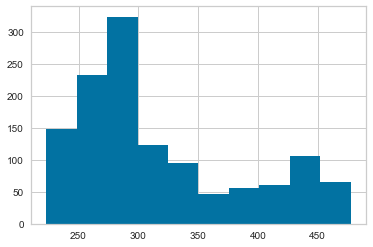

In [5]:
spyDf.Close.hist()

<AxesSubplot:xlabel='Date'>

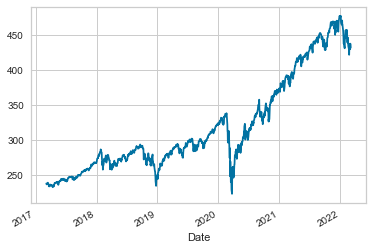

In [6]:
spyDf.Close.plot.line()

## Cross-validation dataset creation <a class="anchor" id="cross-validation"></a>

In [7]:
# Rescale the data 

scaler = MinMaxScaler(feature_range=(0,1))
 
df_scaled = scaler.fit_transform(spyDf.drop(["Close", "Adj Close"], axis=1).to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=[
  'Open', 'High', 'Low', 'Volume'])
 
print("Scaled Dataset Using MinMaxScaler")
df_scaled.head()

Scaled Dataset Using MinMaxScaler


,Open,High,Low,Volume
0,0.037087,0.033720,0.072731,0.094425
1,0.036529,0.032321,0.071761,0.120537
2,0.036450,0.031802,0.070365,0.155663
3,0.033900,0.030204,0.067805,0.189310
4,0.038959,0.033320,0.071102,0.165941


In [8]:
# Now let's create a test/training set
# Let's get a stratfied split this time, so we are not missing categories

X, X_test, y, y_test = train_test_split(df_scaled, 
                                        spyDf.Close, 
                                        test_size=0.2, 
                                        shuffle=False)

print('Shape of train', X.shape)

print("Shape of Validation ", X_test.shape)

X

Shape of train (1008, 4)
Shape of Validation  (252, 4)


,Open,High,Low,Volume
0,0.037087,0.033720,0.072731,0.094425
1,0.036529,0.032321,0.071761,0.120537
2,0.036450,0.031802,0.070365,0.155663
3,0.033900,0.030204,0.067805,0.189310
4,0.038959,0.033320,0.071102,0.165941
...,...,...,...,...
1003,0.627017,0.644187,0.629597,0.228737
1004,0.643867,0.640791,0.650659,0.159498
1005,0.627813,0.627847,0.632467,0.267966
1006,0.609608,0.616540,0.595888,0.438668


In [9]:
X_test_np = np.reshape(X_test.to_numpy(), (X_test.shape[0], X_test.shape[1], 1))

X_train = np.reshape(X.to_numpy(), (X.shape[0], X.shape[1], 1))
X_train

array([[[0.03708719],
        [0.03371954],
        [0.0727308 ],
        [0.09442515]],

       [[0.03652949],
        [0.03232126],
        [0.07176105],
        [0.12053667]],

       [[0.0364498 ],
        [0.03180186],
        [0.07036462],
        [0.15566256]],

       ...,

       [[0.62781344],
        [0.62784651],
        [0.63246703],
        [0.26796616]],

       [[0.60960841],
        [0.61654014],
        [0.59588832],
        [0.43866835]],

       [[0.60658085],
        [0.61957653],
        [0.59883638],
        [0.3542663 ]]])

In [10]:
np.array(y)

array([237.71000671, 237.        , 236.55999756, ..., 381.42001343,
       376.70001221, 383.63000488])

In [11]:
# created scaler
scaler = StandardScaler()
# fit scaler on training dataset
scaler.fit(np.array(y).reshape(-1, 1))
# transform training dataset
trainy = scaler.transform(np.array(y).reshape(-1, 1))
# transform test dataset
testy = scaler.transform(np.array(y_test).reshape(-1, 1))
trainy


array([[-1.37761423],
       [-1.39655718],
       [-1.40829642],
       ...,
       [ 2.45656145],
       [ 2.33063206],
       [ 2.51552391]])

In [12]:
scaler.inverse_transform(trainy)

array([[237.71000671],
       [237.        ],
       [236.55999756],
       ...,
       [381.42001343],
       [376.70001221],
       [383.63000488]])

## RNN Tuning <a class="anchor" id="fit-RNN"></a>

Grid search fit time: 0.0
{'regressor__epochs': 120, 'regressor__learning_rate': 0.001, 'regressor__nodes': 50, 'regressor__num_output': 1, 'regressor__validation_split': 0.1}
Epoch 1/120


2022-03-10 20:31:19.939107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-10 20:31:21.043778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-10 20:31:21.221108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 0.5631 - mean_absolute_percentage_error: 141.5740 - mean_absolute_error: 0.6107

2022-03-10 20:31:24.701204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-10 20:31:24.927177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 7s 205ms/step - loss: 0.5631 - mean_absolute_percentage_error: 141.5740 - mean_absolute_error: 0.6107 - val_loss: 5.1135 - val_mean_absolute_percentage_error: 106.6983 - val_mean_absolute_error: 2.2195
Epoch 2/120
19/19 [==============================] - 3s 137ms/step - loss: 0.4601 - mean_absolute_percentage_error: 478.9820 - mean_absolute_error: 0.5359 - val_loss: 3.2304 - val_mean_absolute_percentage_error: 84.4860 - val_mean_absolute_error: 1.7613
Epoch 3/120
19/19 [==============================] - 3s 132ms/step - loss: 0.3194 - mean_absolute_percentage_error: 325.3539 - mean_absolute_error: 0.4214 - val_loss: 1.4976 - val_mean_absolute_percentage_error: 57.8421 - val_mean_absolute_error: 1.2016
Epoch 4/120
19/19 [==============================] - 2s 129ms/step - loss: 0.2208 - mean_absolute_percentage_error: 332.7567 - mean_absolute_error: 0.3126 - val_loss: 0.8342 - val_mean_absolute_percentage_error: 44.5539 - val_mean_absolute_error: 0.

2022-03-10 20:36:25.212865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/8 [=================>............] - ETA: 0s

2022-03-10 20:36:25.425371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 35ms/step


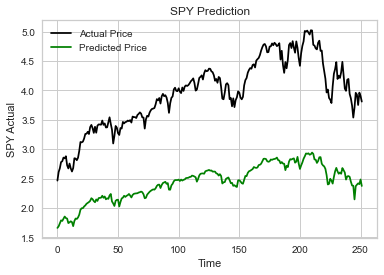

Mean Average Error: 1.518
R2 score: -5.940


In [35]:
# Let's also try adding a convolutional layer in the middle 

# Squash annoying warns
import warnings
warnings.filterwarnings("ignore")

#tf.autograph.set_verbosity(0)
import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)
#logging.getLogger("scikeras").setLevel(logging.ERROR)

def create_lstm_model(nodes=64, num_input=4, num_output=1, learning_rate=0.00001):
    
    all_layers = []
    
    all_layers.append(tf.keras.layers.LSTM(units=50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, input_shape=(4, 1)) )
    
    all_layers.append(tf.keras.layers.LSTM(units=50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True) )
    
    #all_layers.append(tf.keras.layers.LSTM(units=1008, dropout=0.2, recurrent_dropout=0.2, return_sequences=True) )
    
    all_layers.append(tf.keras.layers.LSTM(units=50, dropout=0.2) ) 
                                         
    all_layers.append(tf.keras.layers.Dense(units=1) )
    
    
    model = tf.keras.Sequential(all_layers)
    
    opt = tf.keras.optimizers.Adam()
    
    model.compile(opt, 
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.mean_absolute_percentage_error, tf.keras.metrics.mean_absolute_error])
    return model

def run_lstm():
    
    #define model
    classifier = KerasRegressor(model=create_lstm_model, nodes=None, num_output=None, learning_rate=None, verbose=0)
    
    pipelineKerasCNN = Pipeline([
                            ("classifier", classifier)])
    
    params={'classifier__batch_size':[50], 
        'classifier__epochs':[15],
        'classifier__nodes':[64],
        'classifier__learning_rate': np.linspace(0.00001, 0.0005, num=2),
        'classifier__validation_split':[0.2],
        'classifier__num_output': [1]
        }
    
    gs=HalvingGridSearchCV(estimator=pipelineKerasCNN,
                           param_grid=params, 
                           factor=2,
                           aggressive_elimination=True,
                           cv=2,
                           verbose=10,
                           n_jobs=4)

    start_time = timeit.default_timer()
    #l_grid_result = gs.fit(X, y)
    stop_time = timeit.default_timer()
    
    l_best_params = {
                     'regressor__epochs': 120, 
                     'regressor__learning_rate': 0.001, 
                     'regressor__nodes': 50, 
                     'regressor__num_output': 1, 
                     'regressor__validation_split': 0.1} 
    #l_best_params = l_grid_result.best_params_

    print("Grid search fit time: {time}".format(time=round(stop_time - start_time, 2)))
          
    print(l_best_params)
    
    regressor = KerasRegressor(model=lambda: create_lstm_model( 
                                                                l_best_params["regressor__nodes"], 
                                                                l_best_params["regressor__num_output"], 
                                                                l_best_params["regressor__learning_rate"]), verbose=1)
    
    pipelineKerasCNN = Pipeline([("regressor", regressor)])
    
    start_time = timeit.default_timer()
    
    fit_hist = pipelineKerasCNN.fit(X_train, trainy, 
                                 regressor__batch_size=50,
                                 regressor__epochs=l_best_params["regressor__epochs"],
                                 regressor__validation_split=l_best_params["regressor__validation_split"])
    stop_time = timeit.default_timer()


    print("LSTM with nodes {num_nodes} fit time: {time}".format(time=round(stop_time - start_time, 2),
                                                                num_nodes=l_best_params["regressor__nodes"]))
    
    pipelineKerasCNN.steps[0][1].model().summary()
    ypred = pipelineKerasCNN.predict(X_test_np)
    
    ypred = ypred[len(ypred)-len(testy):]
    
    plt.plot(testy, color = 'black', label = 'Actual Price')
    plt.plot(ypred, color = 'green', label = 'Predicted Price')
    plt.title('SPY Prediction')
    plt.xlabel('Time')
    plt.ylabel('SPY Actual')
    plt.legend()
    plt.show()
    
    # Let's also print the accuracy and recall scores
    print("Mean Average Error: {:.3f}".format(metrics.mean_absolute_error(testy, ypred)))
    print("R2 score: {:.3f}".format(metrics.r2_score(testy, ypred)))
    
    return pipelineKerasCNN, l_best_params

pipelineKerasCNN, l_best_params = run_lstm()


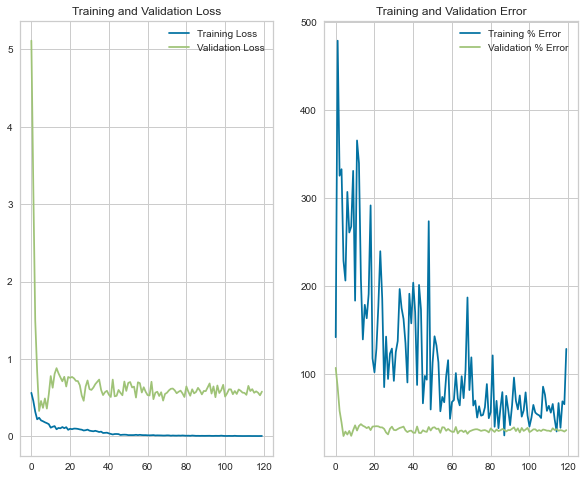

In [36]:
history = pipelineKerasCNN.steps[0][1].history_

loss = history['loss']
val_loss = history['val_loss']

acc = history['mean_absolute_percentage_error']
val_acc = history['val_mean_absolute_percentage_error']

epochs_range = range(l_best_params["regressor__epochs"])

fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(121)


ax1 = plt.plot(epochs_range, loss, label='Training Loss')
ax1 = plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
ax2 = plt.subplot(122)

ax2 = plt.plot(epochs_range, acc, label='Training % Error')
ax2 = plt.plot(epochs_range, val_acc, label='Validation % Error')
plt.legend(loc='upper right')
plt.title('Training and Validation Error')
plt.show()

## Summary <a class="anchor" id="summary"></a>

Working out how to stack the LSTM layers was good here. The predictions we not great, but I was able to improve from a useless model at leaat. Tuning the number of units was key to getting a better prediction, along with turning the learning rate up incredibly high. 